In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import product

from sklearn import preprocessing
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [2]:
def get_dataset(input_file_name):
    dataset = pd.read_csv(input_file_name, sep="\t")
    dataset = dataset.set_index("gene")
    return dataset

def get_labeled_dataset(dataset):
    labeled_dataset = dataset[dataset["class"].notnull()]
    return labeled_dataset

def get_unlabeled_dataset(dataset):
    unlabeled_dataset = dataset[dataset["class"].isnull()]
    return unlabeled_dataset

def get_normalized_dataset(dataset, norm_type):
    dataset_numeric = dataset.select_dtypes(include=[np.number])
    
    if norm_type == "z-score":
        dataset_norm = (dataset_numeric - dataset_numeric.mean()) / dataset_numeric.std()
    elif norm_type == "minmax":
        dataset_norm = (dataset_numeric - dataset_numeric.mean()) / (dataset_numeric.max() - dataset_numeric.min())

    dataset[dataset_norm.columns] = dataset_norm

    return dataset

def print_count_class(dataset):
    print("Total of classes:", sum(dataset["class"].value_counts()))
    print(dataset["class"].value_counts())

In [3]:
def get_metrics(y_test, y_preds):
    cm = confusion_matrix(y_test, y_preds)

    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

    accuracy = (TP + TN) / (TN + FP + FN + TP) 
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = (2 * precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

def grid_random_forest(X, y, nfolds, random_states):
    n_estimators_list = [20, 50, 100, 150, 200, 300, 500]
    max_depth_list = [None, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
    max_features_list = [None, "auto", "sqrt", "log2"]
    criterion_list = ["gini", "entropy"]

    results = [] 
    for element in product(n_estimators_list, max_depth_list, max_features_list, criterion_list):
        n_estimators = element[0]
        max_depth = element[1]
        max_features = element[2]
        criterion = element[3]
        #print(element, end=", ")
        acc_list = []
        for state in random_states:
            model =  RandomForestClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators=n_estimators, random_state=state)
            kfolds = StratifiedKFold(nfolds, shuffle=True, random_state=state)
            y_test_all = []
            y_preds_all = []
            for train_index, test_index in kfolds.split(X, y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                undersample = RandomUnderSampler(sampling_strategy='majority', random_state=state)
                X_train, y_train = undersample.fit_resample(X_train, y_train)
                y_preds = model.fit(X_train, y_train).predict(X_test)

                y_preds_all.extend(y_preds)
                y_test_all.extend(y_test)

            accuracy, precision, recall, f1 = get_metrics(y_test_all, y_preds_all)
            acc_list.append(accuracy)
         
        results.append([n_estimators, max_depth, max_features, criterion, np.mean(acc_list)])
        
    results = pd.DataFrame(results, columns=["n_estimators", "max_depth", "max_features", "criterion", "accuracy"])
    return results


def grid_support_vector_machine(X, y, nfolds, random_states):
    c_list = [1, 2, 4, 6, 8, 10]
    gamma_list = ["auto", "scale", 1, 2, 4, 6, 8, 10]
    kernel_list = ["linear", "rbf", "sigmoid"]
    
    results = [] 
    for element in product(c_list, gamma_list, kernel_list):
        c = element[0]
        gamma = element[1]
        kernel = element[2]
        #print(element, end=", ")
        acc_list = []
        for state in random_states:
            model = svm.SVC(C=c, gamma=gamma, kernel=kernel, probability=True, random_state=state)
            
            kfolds = StratifiedKFold(nfolds, shuffle=True, random_state=state)
            y_test_all = []
            y_preds_all = []
            for train_index, test_index in kfolds.split(X, y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                undersample = RandomUnderSampler(sampling_strategy='majority', random_state=state)
                X_train, y_train = undersample.fit_resample(X_train, y_train)

                y_preds = model.fit(X_train, y_train).predict(X_test)

                y_preds_all.extend(y_preds)
                y_test_all.extend(y_test)

            accuracy, precision, recall, f1 = get_metrics(y_test_all, y_preds_all)
            acc_list.append(accuracy)
         
        results.append([c, gamma, kernel, np.mean(acc_list)])
        
    results = pd.DataFrame(results, columns=["C", "gamma", "kernel", "accuracy"])

    return results

In [4]:
input_file_name = "./data/MutationCell2018_Reactome_HPRD_HuRI_HINT.tsv"

dataset = get_dataset(input_file_name)
print("Full data set:", dataset.shape)
dataset["class"] = dataset["class"].replace({"driver": 1, "false_positive": 0})

unlabeled_dataset = get_unlabeled_dataset(dataset)
print("Unlabeled data set:", unlabeled_dataset.shape)

labeled_dataset = get_labeled_dataset(dataset)
print("Labeled data set:", labeled_dataset.shape)

X = labeled_dataset.drop(columns=["class"])
X = get_normalized_dataset(X, "z-score")
y = labeled_dataset["class"]

Full data set: (16281, 21)
Unlabeled data set: (15405, 21)
Labeled data set: (876, 21)


In [5]:
print_count_class(labeled_dataset)

Total of classes: 876
1.0    647
0.0    229
Name: class, dtype: int64


In [6]:
labeled_dataset.head(5)

,nr_patients,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,...,closeness,betweenness,eigenvector,kcore,clusteringcoeff,leverage,information,bridging,average_neighbors,class
gene,,,,,,,,,,,,,,,,,,,,,
PPP3CA,72.0,2.0,1.0,1.0,0.0,56.0,8.0,0.0,4.0,0.0,...,0.347899,2.793244e-04,0.002085,45,0.108671,0.1123,0.000221,8.814650e-07,120.308511,0.0
PDGFRB,126.0,2.0,0.0,1.0,0.0,110.0,7.0,0.0,6.0,0.0,...,0.381821,6.729387e-04,0.008201,66,0.121341,0.3734,0.000228,5.683809e-07,168.805755,1.0
AKT2,49.0,1.0,0.0,0.0,0.0,46.0,2.0,0.0,0.0,0.0,...,0.395863,1.252243e-03,0.009294,66,0.112614,0.3074,0.000228,8.575544e-07,189.090196,1.0
DROSHA,142.0,5.0,1.0,0.0,1.0,119.0,11.0,0.0,5.0,0.0,...,0.336383,5.053158e-06,0.001700,15,0.275000,-0.7551,0.000181,1.436156e-06,326.812500,1.0
RSPO3,31.0,0.0,0.0,0.0,0.0,25.0,6.0,0.0,0.0,0.0,...,0.307200,1.249506e-08,0.001088,9,0.888889,-0.6431,0.000154,4.993882e-09,435.444444,1.0


In [7]:
X.head(5)

,nr_patients,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,degree,closeness,betweenness,eigenvector,kcore,clusteringcoeff,leverage,information,bridging,average_neighbors
gene,,,,,,,,,,,,,,,,,,,,
PPP3CA,-0.324927,-0.279131,-0.238942,-0.061191,-0.151072,-0.325464,-0.197182,-0.282128,-0.067356,-0.227876,-0.051045,0.228561,-0.138384,-0.312068,0.148522,-0.631818,0.782035,0.587313,-0.205865,-0.634486
PDGFRB,-0.157083,-0.279131,-0.361850,-0.061191,-0.151072,-0.127499,-0.227873,-0.282128,0.099557,-0.227876,1.331280,1.228764,0.082747,0.377381,0.869229,-0.571771,1.371258,0.759845,-0.301178,-0.201095
AKT2,-0.396416,-0.326842,-0.361850,-0.277332,-0.151072,-0.362124,-0.381330,-0.282128,-0.401182,-0.227876,1.158489,1.642789,0.408199,0.500497,0.869229,-0.613131,1.222316,0.751621,-0.213144,-0.019825
DROSHA,-0.107351,-0.135998,-0.238942,-0.277332,0.596605,-0.094505,-0.105108,-0.282128,0.016101,-0.227876,-0.637030,-0.110984,-0.292469,-0.355432,-0.881061,0.156445,-1.175423,-0.383815,-0.037000,1.210919
RSPO3,-0.452365,-0.374553,-0.361850,-0.277332,-0.151072,-0.439111,-0.258565,-0.282128,-0.401182,-0.227876,-0.689619,-0.971448,-0.295301,-0.424476,-1.086977,3.065772,-0.922673,-1.054823,-0.472691,2.181699


In [8]:
# grid-search for SVM and RF, on 3 data sets

random_states = [i for i in range(0, 10)]

def gs_rf_comb():
    gs_rf_parallel = grid_random_forest(X, y, 5, random_states)
    print("gs_rf_parallel")
    return gs_rf_parallel

def gs_svm_comb():    
    gs_svm_parallel = grid_support_vector_machine(X, y, 5, random_states)
    print("gs_svm_parallel")
    return gs_svm_parallel

def gs_rf_mut():
    X_mutation = X.drop(columns=["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])
    gs_rf_mut_parallel = grid_random_forest(X_mutation, y, 5, random_states)
    print("gs_rf_mut_parallel")
    return gs_rf_mut_parallel

def gs_svm_mut():
    X_mutation = X.drop(columns=["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])   
    gs_svm_mut_parallel = grid_support_vector_machine(X_mutation, y, 5, random_states)
    print("gs_svm_mut_parallel")
    return gs_svm_mut_parallel

def gs_rf_gn():
    X_network = X.filter(["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])            
    gs_rf_gn_parallel = grid_random_forest(X_network, y, 5, random_states)
    print("gs_rf_gn_parallel")
    return gs_rf_gn_parallel

def gs_svm_gn():
    X_network = X.filter(["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])  
    gs_svm_gn_parallel = grid_support_vector_machine(X_network, y, 5, random_states)
    print("gs_svm_gn_parallel")
    return gs_svm_gn_parallel
    

from multiprocessing import Pool
pool = Pool()

gs_rf_parallel = pool.apply_async(gs_rf_comb, [])
gs_svm_parallel = pool.apply_async(gs_svm_comb, [])   

gs_rf_mut_parallel = pool.apply_async(gs_rf_mut, [])   
gs_svm_mut_parallel = pool.apply_async(gs_svm_mut, [])   

gs_rf_gn_parallel = pool.apply_async(gs_rf_gn, [])   
gs_svm_gn_parallel = pool.apply_async(gs_svm_gn, [])   


res_gs_rf_parallel = gs_rf_parallel.get()
res_gs_svm_parallel = gs_svm_parallel.get()

res_gs_rf_mut_parallel = gs_rf_mut_parallel.get()
res_gs_svm_mut_parallel = gs_svm_mut_parallel.get()

res_gs_rf_gn_parallel = gs_rf_gn_parallel.get()
res_gs_svm_gn_parallel = gs_svm_gn_parallel.get()

gs_svm_mut_parallel
gs_svm_gn_parallel
gs_svm_parallel
gs_rf_mut_parallel
gs_rf_gn_parallel
gs_rf_parallel


In [9]:
res_gs_svm_parallel.sort_values(by=["accuracy", "C", "gamma"], ascending=[False, True, True])[:5]

,C,gamma,kernel,accuracy
6,1,1,linear,0.849772
9,1,2,linear,0.849772
12,1,4,linear,0.849772
15,1,6,linear,0.849772
18,1,8,linear,0.849772


In [10]:
res_gs_svm_mut_parallel.sort_values(by=["accuracy", "C", "gamma"], ascending=[False, True, True])[:5]

,C,gamma,kernel,accuracy
6,1,1,linear,0.828196
9,1,2,linear,0.828196
12,1,4,linear,0.828196
15,1,6,linear,0.828196
18,1,8,linear,0.828196


In [11]:
res_gs_svm_gn_parallel.sort_values(by=["accuracy", "C", "gamma"], ascending=[False, True, True])[:5]

,C,gamma,kernel,accuracy
22,1,10,rbf,0.700114
19,1,8,rbf,0.681849
46,2,10,rbf,0.676598
70,4,10,rbf,0.673516
94,6,10,rbf,0.671575


In [12]:
res_gs_rf_parallel.sort_values(by=["accuracy", "n_estimators"], ascending=[False, True])[:5]

,n_estimators,max_depth,max_features,criterion,accuracy
528,300,10.0,None,gini,0.826027
520,300,8.0,None,gini,0.825685
536,300,12.0,None,gini,0.825228
424,200,8.0,None,gini,0.825114
432,200,10.0,None,gini,0.824772


In [13]:
res_gs_rf_mut_parallel.sort_values(by=["accuracy", "n_estimators"], ascending=[False, True])[:5]

,n_estimators,max_depth,max_features,criterion,accuracy
250,100,12.0,auto,gini,0.786301
252,100,12.0,sqrt,gini,0.786301
254,100,12.0,log2,gini,0.786301
521,300,8.0,None,entropy,0.786301
538,300,12.0,auto,gini,0.786187


In [14]:
res_gs_rf_gn_parallel.sort_values(by=["accuracy", "n_estimators"], ascending=[False, True])[:5]

,n_estimators,max_depth,max_features,criterion,accuracy
314,150,5.0,auto,gini,0.660388
316,150,5.0,sqrt,gini,0.660388
318,150,5.0,log2,gini,0.660388
411,200,5.0,auto,entropy,0.660160
413,200,5.0,sqrt,entropy,0.660160


In [21]:
'''
Run model with hyper-parameters defined on list 'parameters'.
        
Source of ROC curve on Cross-validation:
 - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
 

Example for SVM:

random_states = [i for i in range(0, 30)]

#[data_set_name, C, gamma, kernel]
parameters = [["DS_{COMB}", 6, 4, "linear"], 
              ["DS_{MUT}", 2, 1, "linear"], 
              ["DS_{GN}", 1, 8, "rbf"]]

model_name = "SVM"
run_model(model_name, X, y, parameters, random_states)
''' 

def run_model(model_name, X, y, parameters, random_states):
    plt.figure(figsize=(10,10))
    
    # para cada conjunto de hiperparametros
    for parameter in parameters:
        data_set_name = parameter[0]
        if model_name == "SVM":
            C = parameter[1]
            gamma = parameter[2]
            kernel = parameter[3]
        elif model_name == "RF":
            n_estimators = parameter[1]
            max_depth = parameter[2]
            max_features = parameter[3]
            criterion = parameter[4]
            
        # removing features, in order to run with different data sets
        if data_set_name == "DS_{COMB}":
            X_ds = X
            color = 'g'
        elif data_set_name == "DS_{MUT}":
            X_ds = X.drop(columns=["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])
            color = 'b'
        elif data_set_name == "DS_{GN}":
            X_ds = X.filter(["degree", "closeness", "betweenness", "eigenvector", "kcore", "clusteringcoeff", "leverage", "information", "bridging", "average_neighbors"])
            color = 'r'

        acc_list = []
        prec_list = []
        recall_list = []
        f1_list = []
        tpr_list = []
        auc_list = []
        base_fpr = np.linspace(0, 1, 100)
        for state in random_states:
            if model_name == "SVM":
                model = svm.SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=state)
            elif model_name == "RF":
                model =  RandomForestClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators=n_estimators, random_state=state)
            
            kfolds = StratifiedKFold(5, shuffle=True, random_state=state)
            y_test_all = []
            y_preds_all = []
            y_probas_all = []
            
            for train_index, test_index in kfolds.split(X_ds, y):
                X_train, X_test = X_ds.iloc[train_index], X_ds.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                # undersampling on training set
                undersample = RandomUnderSampler(sampling_strategy='majority', random_state=state)
                X_train, y_train = undersample.fit_resample(X_train, y_train)

                y_preds = model.fit(X_train, y_train).predict(X_test)
                y_probas = model.fit(X_train, y_train).predict_proba(X_test)

                y_preds_all.extend(y_preds)
                y_test_all.extend(y_test)
                y_probas_all.extend(y_probas)
            
            fpr, tpr, thresholds = roc_curve(y_test_all, np.array(y_probas_all)[:, 1])
            tpr_list.append(np.interp(base_fpr, fpr, tpr))
            tpr_list[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            accuracy, precision, recall, f1 = get_metrics(y_test_all, y_preds_all)
            acc_list.append(accuracy)
            prec_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(base_fpr, mean_tpr)
        std_auc = np.std(auc_list)
        plt.plot(base_fpr, mean_tpr, color=color, label="${}$ - Mean ROC (AUC = {:.3f} $\pm$ {:.3f})".format(data_set_name, mean_auc, std_auc), lw=3, alpha=0.8)
        std_tpr = np.std(tpr_list, axis=0)
        tpr_list_upper = np.minimum(mean_tpr + std_tpr, 1)
        tpr_list_lower = np.maximum(mean_tpr - std_tpr, 0)
        if data_set_name == "DS_{COMB}":
            plt.fill_between(base_fpr, tpr_list_lower, tpr_list_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
        else:
            plt.fill_between(base_fpr, tpr_list_lower, tpr_list_upper, color='grey', alpha=.2)
        print(data_set_name)
        print("Accuracy: {:.3f} | {:.3f}".format(np.mean(acc_list), np.std(acc_list)))
        print("Precision: {:.3f} | {:.3f}".format(np.mean(prec_list), np.std(prec_list)))
        print("Recall: {:.3f} | {:.3f}".format(np.mean(recall_list), np.std(recall_list)))
        print("F1 score: {:.3f} | {:.3f}".format(np.mean(f1_list), np.std(f1_list)))
        print("AUC: {:.3f} | {:.3f}\n".format(np.mean(auc_list), np.std(auc_list)))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='y', alpha=0.8)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of '+model_name,fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()

[['DS_{COMB}', 1, 1, 'linear'], ['DS_{MUT}', 1, 1, 'linear'], ['DS_{GN}', 1, 10, 'rbf']]
DS_{COMB}
Accuracy: 0.850 | 0.007
Precision: 0.916 | 0.005
Recall: 0.877 | 0.007
F1 score: 0.896 | 0.005
AUC: 0.881 | 0.007

DS_{MUT}
Accuracy: 0.828 | 0.006
Precision: 0.898 | 0.004
Recall: 0.865 | 0.009
F1 score: 0.881 | 0.004
AUC: 0.861 | 0.006

DS_{GN}
Accuracy: 0.704 | 0.011
Precision: 0.784 | 0.006
Recall: 0.827 | 0.014
F1 score: 0.805 | 0.008
AUC: 0.643 | 0.017



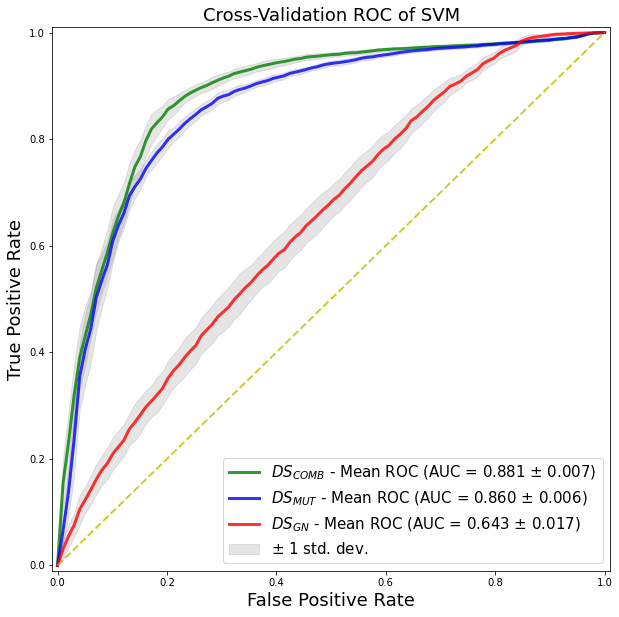

In [22]:
# Running SVM

random_states = [i for i in range(0, 30)]
model_name = "SVM"

#[data_set_name, C, gamma, kernel]
parameters = [["DS_{COMB}", 1, 1, "linear"], 
              ["DS_{MUT}", 1, 1, "linear"], 
              ["DS_{GN}", 1, 10, "rbf"]]

print(parameters)
run_model(model_name, X, y, parameters, random_states)

[['DS_{COMB}', 300, 10, None, 'gini'], ['DS_{MUT}', 100, 12, 'auto', 'gini'], ['DS_{GN}', 150, 5, 'auto', 'gini']]
DS_{COMB}
Accuracy: 0.824 | 0.007
Precision: 0.931 | 0.004
Recall: 0.823 | 0.009
F1 score: 0.874 | 0.006
AUC: 0.887 | 0.005

DS_{MUT}
Accuracy: 0.785 | 0.007
Precision: 0.923 | 0.006
Recall: 0.774 | 0.009
F1 score: 0.842 | 0.006
AUC: 0.867 | 0.005

DS_{GN}
Accuracy: 0.659 | 0.009
Precision: 0.853 | 0.009
Recall: 0.651 | 0.018
F1 score: 0.738 | 0.010
AUC: 0.741 | 0.008



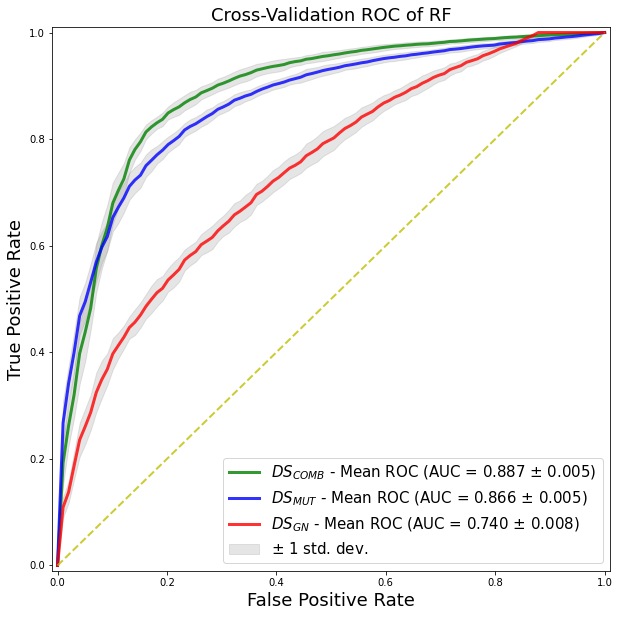

In [23]:
# Running RF

random_states = [i for i in range(0, 30)]
model_name = "RF"

# [data_set_name, n_estimators, max_depth, max_features, criterion]
parameters = [["DS_{COMB}", 300, 10, None, "gini"], 
              ["DS_{MUT}", 100, 12, "auto", "gini"], 
              ["DS_{GN}", 150, 5, "auto", "gini"]]

print(parameters)
run_model(model_name, X, y, parameters, random_states)


# Predicting unlabeled genes
 - Literature-based validation

In [24]:
print("Full data set:", dataset.shape)
print("Unlabeled data set:", unlabeled_dataset.shape)
print("Labeled data set:", labeled_dataset.shape)


y_train = labeled_dataset["class"]
X_train = labeled_dataset.drop(columns=["class"])

unlabeled_X = unlabeled_dataset.drop(columns=["class"])

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
unlabeled_X = pd.DataFrame(scaler.transform(unlabeled_X), index=unlabeled_X.index, columns=unlabeled_X.columns)

print(X_train.shape)

Full data set: (16281, 21)
Unlabeled data set: (15405, 21)
Labeled data set: (876, 21)
(876, 20)


In [25]:
unlabeled_X.head(5)

,nr_patients,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,degree,closeness,betweenness,eigenvector,kcore,clusteringcoeff,leverage,information,bridging,average_neighbors
gene,,,,,,,,,,,,,,,,,,,,
SDHAF4,-0.508603,-0.374767,-0.362057,-0.277490,-0.151158,-0.494384,-0.381548,-0.282289,-0.317907,-0.228006,-0.727597,-2.418979,-0.293681,-0.546562,-1.293632,-1.147483,-0.844396,-2.264180,0.148466,-1.350694
PPP1R13B,-0.266023,-0.040599,-0.116100,0.155039,-0.151158,-0.263292,-0.258712,-0.282289,-0.317907,-0.228006,-0.193895,0.197992,-0.189475,-0.300751,-0.091767,-0.939011,0.690807,0.525881,-0.174485,-0.686726
PHRF1,-0.032772,-0.136076,0.006879,0.155039,-0.151158,0.015485,-0.258712,-0.282289,-0.317907,-0.228006,-0.742631,-1.669980,-0.294208,-0.542230,-1.327971,-1.147483,-1.302767,-3.124331,2.524196,-0.396186
DGKA,-0.353103,-0.231552,-0.362057,-0.277490,-0.151158,-0.332986,-0.320130,-0.282289,-0.234403,-0.228006,-0.629877,-0.746467,-0.290333,-0.490713,-0.847225,-0.833682,-1.038583,-0.326871,0.304291,0.054572
SBK2,-0.440183,-0.327029,-0.362057,-0.277490,-0.151158,-0.413685,-0.381548,-0.282289,-0.401411,-0.228006,-0.750148,-1.469933,-0.295477,-0.534772,-1.362310,-1.147483,-1.720269,-3.770243,-0.474482,2.867469


In [26]:
X_train.head(5)

,nr_patients,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,degree,closeness,betweenness,eigenvector,kcore,clusteringcoeff,leverage,information,bridging,average_neighbors
0,-0.325113,-0.279290,-0.239078,-0.061226,-0.151158,-0.325650,-0.197294,-0.282289,-0.067394,-0.228006,-0.051074,0.228692,-0.138463,-0.312246,0.148606,-0.632179,0.782482,0.587648,-0.205983,-0.634849
1,-0.157172,-0.279290,-0.362057,-0.061226,-0.151158,-0.127572,-0.228003,-0.282289,0.099614,-0.228006,1.332040,1.229466,0.082794,0.377597,0.869726,-0.572097,1.372041,0.760279,-0.301350,-0.201210
2,-0.396643,-0.327029,-0.362057,-0.277490,-0.151158,-0.362331,-0.381548,-0.282289,-0.401411,-0.228006,1.159151,1.643728,0.408432,0.500783,0.869726,-0.613481,1.223014,0.752050,-0.213266,-0.019836
3,-0.107412,-0.136076,-0.239078,-0.277490,0.596946,-0.094559,-0.105168,-0.282289,0.016110,-0.228006,-0.637394,-0.111048,-0.292636,-0.355635,-0.881564,0.156535,-1.176094,-0.384034,-0.037021,1.211611
4,-0.452623,-0.374767,-0.362057,-0.277490,-0.151158,-0.439362,-0.258712,-0.282289,-0.401411,-0.228006,-0.690013,-0.972003,-0.295470,-0.424719,-1.087598,3.067524,-0.923200,-1.055425,-0.472961,2.182946


In [40]:
model_svm = svm.SVC(C=1, gamma=1, kernel="linear", probability=True)
model_svm.fit(X_train, y_train)

unlabeled_ypreds_svm = model_svm.predict(unlabeled_X)
unlabeled_yprobas_svm = model_svm.predict_proba(unlabeled_X)

unlabeled_ypreds = unlabeled_ypreds_svm
unlabeled_yprobas = unlabeled_yprobas_svm

result_svm = pd.concat([pd.DataFrame(unlabeled_X.index), pd.DataFrame(unlabeled_ypreds, columns=["predicted_as"]), pd.DataFrame(unlabeled_yprobas[:, 0], columns=["prob_false_positive"]), pd.DataFrame(unlabeled_yprobas[:, 1], columns=["prob_driver"])],axis=1)
result_svm = result_svm.set_index("gene")
result_svm.to_csv("prediction_svm.tsv", sep="\t")

result_svm

,predicted_as,prob_false_positive,prob_driver
gene,,,
SDHAF4,1.0,0.202957,0.797043
PPP1R13B,1.0,0.077220,0.922780
PHRF1,1.0,0.286869,0.713131
DGKA,1.0,0.248860,0.751140
SBK2,1.0,0.381185,0.618815
...,...,...,...
SLC22A5,1.0,0.098377,0.901623
KRTAP6-2,1.0,0.047939,0.952061
CHST3,1.0,0.068871,0.931129


In [39]:
model_rf =  RandomForestClassifier(n_estimators=100, max_depth=6, max_features=None, criterion="entropy")
model_rf.fit(X_train, y_train)

unlabeled_ypreds_rf = model_rf.predict(unlabeled_X)
unlabeled_yprobas_rf = model_rf.predict_proba(unlabeled_X)

unlabeled_ypreds = unlabeled_ypreds_rf
unlabeled_yprobas = unlabeled_yprobas_rf

result_rf = pd.concat([pd.DataFrame(unlabeled_X.index), pd.DataFrame(unlabeled_ypreds, columns=["predicted_as"]), pd.DataFrame(unlabeled_yprobas[:, 0], columns=["prob_false_positive"]), pd.DataFrame(unlabeled_yprobas[:, 1], columns=["prob_driver"])],axis=1)
result_rf = result_rf.set_index("gene")
result_rf.to_csv("prediction_rf.tsv", sep="\t")

result_rf

,predicted_as,prob_false_positive,prob_driver
gene,,,
SDHAF4,1.0,0.005141,0.994859
PPP1R13B,1.0,0.139177,0.860823
PHRF1,0.0,0.682961,0.317039
DGKA,1.0,0.055191,0.944809
SBK2,1.0,0.081379,0.918621
...,...,...,...
SLC22A5,1.0,0.069467,0.930533
KRTAP6-2,1.0,0.000197,0.999803
CHST3,1.0,0.040421,0.959579


In [29]:
# all unlabeled genes
unlabeled_genes = list(unlabeled_X.index)
print(len(unlabeled_genes))
str_unlabeled_genes = "\n".join(unlabeled_genes)
text_file = open("unlabeled_genes.txt", "w")
text_file.write(str_unlabeled_genes)
text_file.close()

15405


In [30]:
intogen_file_name = "./data/list_exclusive_intogen.txt"
intogen_genes = pd.read_csv(intogen_file_name, usecols=[0], names=["gene"], sep='\t')
intogen_genes = list(intogen_genes["gene"])
print("Unlabeled genes contained in IntOGen:", len(intogen_genes))


non_driver_list_svm = []
driver_list_svm = []
driver = 0
nondriver = 0
for gene in intogen_genes:
    if gene in list(result_svm.index):
        row = result_svm.loc[gene]
        #print(gene, row.name, row.predicted_as)
        if result_svm.loc[gene].predicted_as > 0:
            driver = driver + 1
            driver_list_svm.append(gene)
        else:
            nondriver = nondriver + 1
            non_driver_list_svm.append(gene)
            print(gene)

print("Total de genes avaliados: ", (driver + nondriver))
print("Genes preditos como driver que estão contidos no intogen: ", driver, driver/(driver + nondriver))
print("Genes preditos como nondriver estão contidos no intogen: ", nondriver, nondriver/(driver + nondriver))
print(driver/(driver + nondriver))


Unlabeled genes contained in IntOGen: 139
KEL
ZNF208
HSPG2
CR1
PTMA
ZNF93
TLL1
SOHLH2
ZNF721
ZNF814
SP140
MAP2
Total de genes avaliados:  131
Genes preditos como driver que estão contidos no intogen:  119 0.9083969465648855
Genes preditos como nondriver estão contidos no intogen:  12 0.0916030534351145
0.9083969465648855


In [31]:
intogen_file_name = "./data/list_exclusive_intogen.txt"
intogen_genes = pd.read_csv(intogen_file_name, usecols=[0], names=["gene"], sep='\t')
intogen_genes = list(intogen_genes["gene"])

non_driver_list_rf = []
driver_list_rf = []
driver = 0
nondriver = 0
for gene in intogen_genes:
    if gene in list(result_rf.index):
        row = result_rf.loc[gene]
        #print(gene, row.name, row.predicted_as)
        if result_rf.loc[gene].predicted_as > 0:
            driver = driver + 1
            driver_list_rf.append(gene)
        else:
            nondriver = nondriver + 1
            non_driver_list_rf.append(gene)
            print(gene)

print("Total de genes avaliados: ", (driver + nondriver))
print("Genes preditos como driver que estão contidos no intogen: ", driver, driver/(driver + nondriver))
print("Genes preditos como nondriver que estão contidos no intogen: ", nondriver, nondriver/(driver + nondriver))
print(driver/(driver + nondriver))

MGA
KEL
ZNF208
HSPG2
FGD5
CR1
RBFOX1
ENPEP
TLL1
SFMBT2
MCM3AP
SP140
ADGRB1
MAP2
DCSTAMP
Total de genes avaliados:  131
Genes preditos como driver que estão contidos no intogen:  116 0.8854961832061069
Genes preditos como nondriver que estão contidos no intogen:  15 0.11450381679389313
0.8854961832061069


In [32]:
print("SVM:")
print("intOGen genes classified as false-drivers", len(non_driver_list_svm))
print("intOGen genes classified as drivers", len(driver_list_svm))
print("\nRF:")
print("intOGen genes classified as false-drivers", len(non_driver_list_rf))
print("intOGen genes classified as drivers", len(driver_list_rf))

SVM:
intOGen genes classified as false-drivers 12
intOGen genes classified as drivers 119

RF:
intOGen genes classified as false-drivers 15
intOGen genes classified as drivers 116


In [33]:
print("SVM")
FD_svm = non_driver_list_svm
D_svm = driver_list_svm
print("******************** FD ********************")
print(len(FD_svm))
print("\n".join(FD_svm))
print("******************** D ********************")
print(len(D_svm))
print("\n".join(D_svm))

SVM
******************** FD ********************
12
KEL
ZNF208
HSPG2
CR1
PTMA
ZNF93
TLL1
SOHLH2
ZNF721
ZNF814
SP140
MAP2
******************** D ********************
119
RASA1
MGA
ALB
ZNF165
ZNF148
TRIM49C
NIPBL
AJUBA
FBLN1
PARP4
DHX9
EHD2
IRAK1
CNOT9
EPHA2
FGD5
PRR14
EGR2
KLHL36
NPRL2
TCIRG1
SIN3A
BRD7
RBFOX1
ZFP36L1
FN1
ATG7
ENPEP
RBM39
ZNF680
IFNGR1
UBE2D2
DAZAP1
SATB1
LTB
TFAP4
RELA
RIPK1
MAP2K7
UGT2B17
GNAI2
HGF
DUSP16
ING1
PAK2
WDR45
MEF2B
TCF4
TOP2A
NXF1
WNK4
SFMBT2
RHPN2
LOX
EFTUD2
SOS1
HLA-B
RPS6KA3
GNA13
IRF1
NKTR
RPS3A
NPEPPS
INO80
FOXA2
SOX17
ARHGAP35
NRP1
TGIF1
KIFC1
CD58
IFNAR1
PTPN14
POU2F2
GTF2I
RNF6
DTX1
RBFOX2
RBM38
PDPR
NT5C3A
PRKD2
HTRA2
DIS3
U2AF2
NEFH
RASA2
LPAR4
PRKCD
MCM3AP
ZXDB
USP9X
RXRA
ZNF626
ZBTB7B
MARK2
DOT1L
IKZF3
UBE2A
TRAF3
FOXD4L1
KLHL6
SMARCA1
RRAS2
ZNF780A
BMPR2
SUSD2
NFKBIA
ADGRB1
KLF5
KDM3B
ATF7IP
DCSTAMP
KMT2B
RGL3
LDB1
ESRRA
RRAGC
ZCRB1


In [34]:
print("RF")
FD_rf = non_driver_list_rf
D_rf = driver_list_rf
print("******************** FD ********************")
print(len(FD_rf))
print("\n".join(FD_rf))
print("******************** D ********************")
print(len(D_rf))
print("\n".join(D_rf))

RF
******************** FD ********************
15
MGA
KEL
ZNF208
HSPG2
FGD5
CR1
RBFOX1
ENPEP
TLL1
SFMBT2
MCM3AP
SP140
ADGRB1
MAP2
DCSTAMP
******************** D ********************
116
RASA1
ALB
ZNF165
ZNF148
TRIM49C
NIPBL
AJUBA
FBLN1
PARP4
DHX9
EHD2
IRAK1
CNOT9
EPHA2
PRR14
EGR2
KLHL36
NPRL2
PTMA
TCIRG1
SIN3A
BRD7
ZFP36L1
FN1
ZNF93
ATG7
RBM39
ZNF680
IFNGR1
UBE2D2
DAZAP1
SATB1
LTB
TFAP4
RELA
RIPK1
MAP2K7
UGT2B17
GNAI2
HGF
DUSP16
ING1
PAK2
WDR45
MEF2B
TCF4
TOP2A
NXF1
WNK4
RHPN2
LOX
EFTUD2
SOS1
HLA-B
RPS6KA3
GNA13
IRF1
NKTR
RPS3A
NPEPPS
INO80
FOXA2
SOX17
ARHGAP35
NRP1
TGIF1
KIFC1
CD58
IFNAR1
PTPN14
POU2F2
GTF2I
RNF6
DTX1
RBFOX2
RBM38
PDPR
SOHLH2
NT5C3A
PRKD2
HTRA2
DIS3
ZNF721
U2AF2
NEFH
RASA2
LPAR4
PRKCD
ZXDB
USP9X
RXRA
ZNF626
ZBTB7B
MARK2
DOT1L
IKZF3
UBE2A
TRAF3
FOXD4L1
KLHL6
SMARCA1
RRAS2
ZNF780A
BMPR2
ZNF814
SUSD2
NFKBIA
KLF5
KDM3B
ATF7IP
KMT2B
RGL3
LDB1
ESRRA
RRAGC
ZCRB1


In [37]:
input_file_name = "./analyses/analyses_results.tsv"
df_results = pd.read_csv(input_file_name, sep='\t')
df_results = df_results.set_index("citations")
df_results

,FD_driver_citations,FD_oncogene_citations,FD_tumor_suppressor_citations,FD_all_citations,D_driver_citations,D_oncogene_citations,D_tumor_suppressor_citations,D_all_citations
citations,,,,,,,,
1_citation_SVM,0.00,0.08,0.17,0.25,0.19,0.47,0.34,0.63
1_citation_RF,0.13,0.20,0.13,0.40,0.18,0.47,0.35,0.62
3_citation_SVM,0.00,0.00,0.08,0.08,0.04,0.15,0.18,0.33
3_citation_RF,0.00,0.07,0.07,0.20,0.04,0.15,0.18,0.32
10_citation_SVM,0.00,0.00,0.00,0.00,0.00,0.04,0.05,0.13
10_citation_RF,0.00,0.00,0.00,0.00,0.00,0.04,0.05,0.13


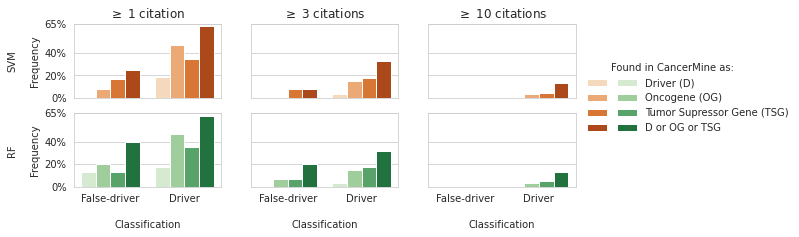

In [38]:
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from matplotlib import patches as mpatches


citations = ["$\geq$ 1 citation SVM", "$\geq$ 3 citations SVM", "$\geq$ 10 citations SVM", "$\geq$ 1 citation RF", "$\geq$ 3 citations RF", "$\geq$ 10 citations RF"]
rows = ["1_citation_SVM", "3_citation_SVM", "10_citation_SVM", "1_citation_RF", "3_citation_RF", "10_citation_RF"]

data_dict = {}
data = []
for i in range(0, len(citations)):
    citation = citations[i]
    row = rows[i]
    fd_driver_citation = list(df_results.loc[row][0:4])
    d_driver_citation = list(df_results.loc[row][4:8])

    data.append([citation, "Driver (D)", "classified_FD", fd_driver_citation[0]])
    data.append([citation, "Driver (D)", "classified_D", d_driver_citation[0]])

    data.append([citation, "Oncogene (OG)", "classified_FD", fd_driver_citation[1]])
    data.append([citation, "Oncogene (OG)", "classified_D", d_driver_citation[1]])

    data.append([citation, "Tumor Supressor Gene (TSG)", "classified_FD", fd_driver_citation[2]])
    data.append([citation, "Tumor Supressor Gene (TSG)", "classified_D", d_driver_citation[2]])

    data.append([citation, "D or OG or TSG", "classified_FD", fd_driver_citation[3]])
    data.append([citation, "D or OG or TSG", "classified_D", d_driver_citation[3]])

df = pd.DataFrame(data, columns=["citation", "citation_type", "classified_as", "frequency"])

    
ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(3 * ncols, 1.5 * nrows))
barWidth = 0.10

sns.set_style("whitegrid")

plotRow=0
plotCol=0
for citation in citations:
    df_citations = df[df["citation"] == citation]
    if citation.endswith("SVM"):
        g = sns.barplot(ax=ax[plotRow, plotCol], x="classified_as", y="frequency", hue="citation_type", data=df_citations, palette="Oranges")
    else:
        g = sns.barplot(ax=ax[plotRow, plotCol], x="classified_as", y="frequency", hue="citation_type", data=df_citations, palette="Greens")
    
    g.set_yticks([0, 0.20, 0.4, 0.65]) 
    g.set_yticklabels(["0%", "20%", "40%","65%"])
    if plotCol == 0 and plotRow == 0:
        g.set(ylabel="SVM\n\nFrequency")
    elif plotCol == 0 and plotRow == 1:
        g.set(ylabel="RF\n\nFrequency")
    else:
        g.set(ylabel="")
        g.set(yticklabels=[])
        
       
    if plotRow == 0:
        g.set(xlabel="")
        g.set_title(citation[:-4])
        g.set_xticklabels([])
    else:
        g.set_xticklabels(["False-driver", "Driver"])
        g.set(xlabel="\nClassification")
    
    if plotCol == 2 and plotRow == 0:
        g.legend(title="Found in CancerMine as:",
                 loc='center right', bbox_to_anchor=(2.3, 0.00), ncol=1, frameon=False)
        plt.setp(g.get_legend().get_texts(), color="white")
    elif plotCol == 2 and plotRow == 1:
        g.legend(loc='center right', bbox_to_anchor=(2.5, 1.1), ncol=1, frameon=False)
        

    else:
         g.legend_.remove()

    g.set(ylim=(0, 0.65))

    
    plotCol+=1
    if plotCol == 3:
        plotRow = plotRow + 1
        plotCol = 0 

plt.show()